# Описание проекта
Необходимо скорректировать рекламный бюджет телекоммуникационной компании "МГС". Для этого коммерческий департамент хочет понять, какой тариф приносит больше денег. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».   

**Дано**: данные 500 пользователей «МГС».     

**Задачи**:
- сделать предварительный анализ тарифов на небольшой выборке клиентов
- кто является клиентами
- откуда пользователи
- каким тарифом пользуются
- сколько звонков и сообщений каждый отправил за 2018 год

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

In [2]:
df_calls = pd.read_csv('C:/Users/erokh/Downloads/calls.csv')
print('ТАБЛИЦА CALLS')
print(df_calls.info())
display(df_calls.head())

ТАБЛИЦА CALLS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

Стоит заменить тип данных в столбце call_date на datetime. Пропусков нет.

In [3]:
df_internet = pd.read_csv('C:/Users/erokh/Downloads/internet.csv')
print('ТАБЛИЦА INTERNET')
print(df_internet.info()) #ЗАМЕЧЕН СТРАННЫЙ СТОЛБЦЕ Unnamed: 0
display(df_internet.head())

ТАБЛИЦА INTERNET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000

Столбец Unnamed: 0 стоит удалить, поскольку он полностью дуюблирует индек. Столбец session_date привезти к datetime.

In [4]:
df_messages = pd.read_csv('C:/Users/erokh/Downloads/messages.csv')
print('ТАБЛИЦА MESSAGES')
print(df_messages.info())
display(df_messages.head())

ТАБЛИЦА MESSAGES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

Столбец message_date привезти к datetime.

In [5]:
df_tariffs = pd.read_csv('C:/Users/erokh/Downloads/tariffs.csv')
print('ТАБЛИЦА TARIFFS')
print(df_tariffs.info())
display(df_tariffs.head())

ТАБЛИЦА TARIFFS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

In [6]:
df_users = pd.read_csv('C:/Users/erokh/Downloads/users.csv')
print('ТАБЛИЦА USERS')
print(df_users.info())  #В СТОЛБЦЕ churn_date 462 ПРОПУСКА (38 ЗАПОЛНЕННЫХ ЗНАЧЕНИЙ ВСЕГО)
display(df_users.head())

ТАБЛИЦА USERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra

In [7]:
df_users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

В столбце churn_date присутствуют пропуски. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

In [8]:
SMART_COST = df_tariffs['rub_monthly_fee'][0] #550
SMART_MINUTES = df_tariffs['minutes_included'][0] #500
SMART_MESSAGES = df_tariffs['messages_included'][0] #50
SMART_INTERNET_MB = df_tariffs['mb_per_month_included'][0]#15360
SMART_INTERNET_GB = np.ceil(df_tariffs['mb_per_month_included'][0] / 1000)#16
SMART_MIN_COST = df_tariffs['rub_per_minute'][0]#3
SMART_MESSAGE_COST = df_tariffs['rub_per_message'][0]#3
SMART_1000MB = df_tariffs['rub_per_gb'][0]#200

ULTRA_COST = df_tariffs['rub_monthly_fee'][1]#1950
ULTRA_MINUTES = df_tariffs['minutes_included'][1]#3000
ULTRA_MESSAGES = df_tariffs['messages_included'][1]#1000
ULTRA_INTERNET_MB = df_tariffs['mb_per_month_included'][1]#30720
ULTRA_INTERNET_GB = np.ceil(df_tariffs['mb_per_month_included'][0] / 1000)#31
ULTRA_MIN_COST = df_tariffs['rub_per_minute'][1]#1
ULTRA_MESSAGE_COST = df_tariffs['rub_per_message'][1]#1
ULTRA_1000MB = df_tariffs['rub_per_gb'][1]#150

## Предобработка данных

### Замена типа данных, избавление от ненужных значений

#### df_calls

0.00     39613
5.50       142
4.49       142
6.15       141
6.38       141
         ...  
26.32        1
24.51        1
27.24        1
29.89        1
27.43        1
Name: duration, Length: 2871, dtype: int64

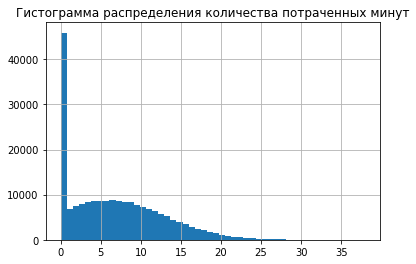

In [9]:
df_calls['duration'].hist(bins = 50);
plt.title('Гистограмма распределения количества потраченных минут');
df_calls['duration'].value_counts()

Много нулевых значений в столбце 'duration', можно предположить, что звонок просто не состоялся.

In [10]:
#Замена типа данных у столбца 'call_date' df_calls
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%dT%H:%M:%S')
df_calls['duration'] = df_calls['duration'].apply(np.ceil) #ОКРУГЛЯЕМ ЗНАЧЕНИЯ ВВЕРХ
df_calls['duration'] = df_calls[df_calls['duration'] != 0]['duration'] ##нельзя заполнять нулевые строки, поскольку может
#измениться кол-во потраченных минут за месяц и, как следствие, доход с клиента
df_calls

id  call_date  duration  user_id
0         1000_0 2018-07-25       NaN     1000
1         1000_1 2018-08-17       NaN     1000
2         1000_2 2018-06-11       3.0     1000
3         1000_3 2018-09-21      14.0     1000
4         1000_4 2018-12-15       6.0     1000
...          ...        ...       ...      ...
202602  1499_215 2018-12-26       1.0     1499
202603  1499_216 2018-10-18      19.0     1499
202604  1499_217 2018-11-10      11.0     1499
202605  1499_218 2018-10-06       5.0     1499
202606  1499_219 2018-12-14      20.0     1499

[202607 rows x 4 columns]

#### df_internet

Количество строк с 0 потраченных мб: 19598


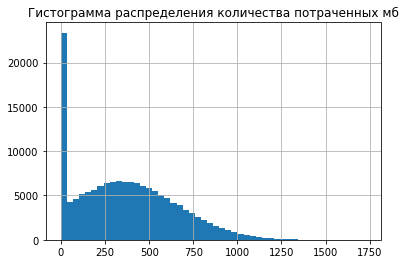

In [11]:
df_internet['mb_used'].hist(bins = 50);
plt.title('Гистограмма распределения количества потраченных мб');
print('Количество строк с 0 потраченных мб:', len(df_internet[df_internet['mb_used']==0]))

In [12]:
#Замена типа данных в df_internet
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%dT%H:%M:%S')
df_internet = df_internet.drop('Unnamed: 0', 1) #удаляем столбец Unnamed: 0
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil) #ОКРУГЛЯЕМ ЗНАЧЕНИЯ ВВЕРХ
df_internet['mb_used'] = df_internet[df_internet['mb_used']!=0]['mb_used'] 
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Заполнять строки с нулевыми значениями не будем, поскольку может измениться количество потраченных мб за месяц и, как следствие, доход с клиента.

#### df_messages

In [13]:
df_messages.info()
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%dT%H:%M:%S')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### df_users

user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra

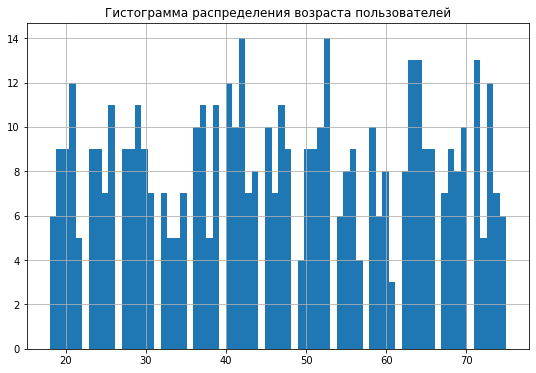

In [14]:
df_users['age'].hist(bins = 70, figsize = (9, 6));
plt.title('Гистограмма распределения возраста пользователей');
df_users.head()

### Проверка на дубликаты

In [15]:
print('Кол-во дубликатов в df_calls:', df_calls.duplicated().sum())
print('Кол-во дубликатов в df_internet:', df_internet.duplicated().sum())
print('Кол-во дубликатов в df_messages:', df_messages.duplicated().sum())
print('Кол-во дубликатов в df_users:', df_users.duplicated().sum())
#Полные повторы строк отсутствуют

Кол-во дубликатов в df_calls: 0
Кол-во дубликатов в df_internet: 0
Кол-во дубликатов в df_messages: 0
Кол-во дубликатов в df_users: 0


In [16]:
print('Кол-во уникальных user_id в df_calls:', len(df_calls['user_id'].unique()))
print('Общее кол-во значений user_id в df_calls:', len(df_calls['user_id']))
print()

print('Кол-во уникальных user_id в df_internet:', len(df_internet['user_id'].unique()))
print('Общее кол-во значений user_id в df_internet:', len(df_internet['user_id']))
print()

print('Кол-во уникальных user_id в df_messages:', len(df_messages['user_id'].unique()))
print('Общее кол-во значений user_id в df_messages:', len(df_messages['user_id']))
print()

print('Кол-во уникальных user_id в df_users:', len(df_users['user_id'].unique()))
print('Общее кол-во значений user_id в df_users:', len(df_users['user_id']))

Кол-во уникальных user_id в df_calls: 492
Общее кол-во значений user_id в df_calls: 202607

Кол-во уникальных user_id в df_internet: 497
Общее кол-во значений user_id в df_internet: 149396

Кол-во уникальных user_id в df_messages: 426
Общее кол-во значений user_id в df_messages: 123036

Кол-во уникальных user_id в df_users: 500
Общее кол-во значений user_id в df_users: 500


Можем заметить, что у каждого фрейма разное кол-во уникальных user_id. Это говорит о том, что у нас есть пользователи, о которых нет информации: ни сколько потратили интернета, ни сколько минут проговорили, ни сколько смс отправили. Повторы по каждому user_id объясняются, как история операций. 

In [17]:
unique_user_id = pd.Series(df_users['user_id'].unique(), index = df_users['user_id'].unique())
df_messages_missing_id = pd.Series(unique_user_id.isin(df_messages['user_id'])[unique_user_id.isin(df_messages['user_id']) == False].index)

df_internet_missing_id = pd.Series(unique_user_id.isin(df_internet['user_id'])[unique_user_id.isin(df_internet['user_id']) == False].index)

df_calls_missing_id = pd.Series(unique_user_id.isin(df_calls['user_id'])[unique_user_id.isin(df_calls['user_id']) == False].index)

pd.concat([df_messages_missing_id, df_internet_missing_id, df_calls_missing_id], axis = 0).value_counts().head()

1371    3
1128    3
1024    1
1118    1
1116    1
dtype: int64

Можем заметить, что имеется 2 пользователя, id которых нет ни в одном датафрейме, кроме df_users.

Далее проверим уникальность id в каждом датафрейме.

In [18]:
print('Количество уникальных значений id в df_calls:', len(df_calls['id'].unique()))
print('Количество строк в df_calls[''id'']', len(df_calls['id']))
print('')

print('Количество уникальных значений id в df_internet:', len(df_internet['id'].unique()))
print('Количество строк в df_internet[''id'']', len(df_internet['id']))
print('')

print('Количество уникальных значений id в df_messages:', len(df_messages['id'].unique()))
print('Количество строк в df_messages[''id'']', len(df_messages['id']))
print('')

Количество уникальных значений id в df_calls: 202607
Количество строк в df_calls[id] 202607

Количество уникальных значений id в df_internet: 149396
Количество строк в df_internet[id] 149396

Количество уникальных значений id в df_messages: 123036
Количество строк в df_messages[id] 123036



Полные повторы строк по столбцу id в фреймах отсутствуют.

###  Поиск аномальных значений.

7.0     11510
6.0     11457
5.0     11411
8.0     11272
9.0     10973
4.0     10918
3.0     10362
10.0    10186
11.0     9385
2.0      9194
Name: duration, dtype: int64


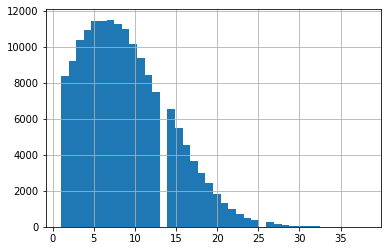

In [19]:
df_calls['duration'].hist(bins = 40)
print(df_calls['duration'].value_counts().head(10))

Наиболее частая длительность звонков не превышает 11 секунд. Можно объяснить тем, что человек берет трубку, слышит, например рекламу или робота и сразу скидывает.

In [20]:
df_calls['month'] = df_calls['call_date'].dt.month
print(df_calls['call_date'].min())
print(df_calls['call_date'].max())

2018-01-01 00:00:00
2018-12-31 00:00:00


Видим, что данные представлены за один год

12    33987
11    29501
10    27146
9     24061
8     21488
7     18298
6     14716
5     12647
4      9272
3      6687
2      3328
1      1476
Name: month, dtype: int64

12     NaN
11    0.13
10    0.08
9     0.11
8     0.11
7     0.15
6     0.20
5     0.14
4     0.27
3     0.28
2     0.50
1     0.56
Name: month, dtype: float64


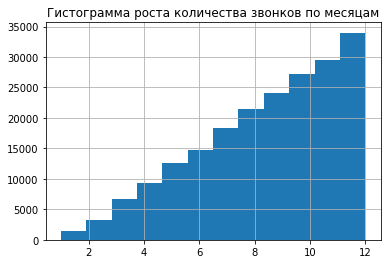

In [21]:
print(df_calls['month'].value_counts())
print()
print(abs(round(df_calls['month'].value_counts().pct_change(), 2)))#прирост количества звонков по месяцам
df_calls['month'].hist(bins = 12);
plt.title('Гистограмма роста количества звонков по месяцам');

Видим, что кол-во звоноков стабильно росло с каждым месяцем.

2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
Name: session_date, dtype: int64

Строк с 0 потраченных мб: 19598


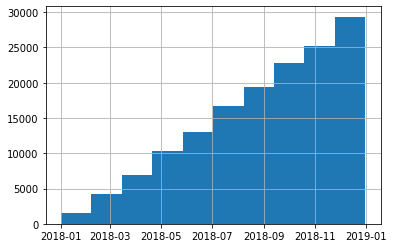

In [22]:
print(df_internet['session_date'].value_counts().head())
df_internet['session_date'].hist()
print()
print('Строк с 0 потраченных мб:', df_internet['mb_used'].isnull().sum())#19598 строк с нулевым траффиком
#Предположение: клиент пытался зайти в сеть, например, загрузить сайт, но сеть плохо ловила
#и загрузить не получилось, но попытка входа зачлась

Количество выходов в интернет росло также равномерно, как и количество звонков.

2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-26    699
2018-12-28    699
2018-12-22    687
2018-12-25    684
2018-12-23    676
2018-12-18    675
2018-12-12    674
2018-12-13    671
2018-12-08    666
2018-11-26    665
2018-12-04    661
Name: message_date, dtype: int64

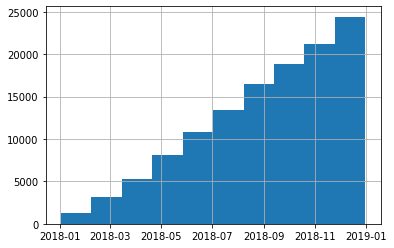

In [23]:
df_messages['message_date'].hist()
df_messages['message_date'].value_counts().head(15)

Больше всего смс также отправлялось в декабре, особенно под новый год.

#### Вывод

На этапе предобработки были проделаны следующие шаги:
 - Изменены типы данных некоторых столбцов
 - Обнаружен и удален пустой столбец "Unnamed: 0" в фрейме df_internet
 - Проведена проверка на дубликаты, полных дубликтов не обнаружено
 - Замечены нулевые значения в столбце mb_used, сделано предположение о природе их происхождения
 - Анализ столбца duration показал, что наиболее частые продолжительности звонков - менее 10 секунд
 - Подсчитано количество звонков и их суммарная продолжительность. Данные показатели росли на протяжении всего года, это же касается и интернета с смс

## Подсчет метрик для каждого пользователя

### Кол-во звонков, смс и интернета

In [24]:
#количество сделанных звонков и израсходованных минут разговора по месяцам
df_calls['month'] = df_calls['call_date'].dt.month
user_calls = df_calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
user_calls

user_id  month  duration  id
0        1000      5     159.0  22
1        1000      6     172.0  43
2        1000      7     340.0  47
3        1000      8     408.0  52
4        1000      9     466.0  58
...       ...    ...       ...  ..
3169     1498     10     247.0  41
3170     1499      9      70.0   9
3171     1499     10     449.0  68
3172     1499     11     612.0  74
3173     1499     12     492.0  69

[3174 rows x 4 columns]

In [25]:
#количество отправленных сообщений по месяцам
df_messages['month'] = df_messages['message_date'].dt.month
user_messages = df_messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
user_messages

user_id  month  id
0        1000      5  22
1        1000      6  60
2        1000      7  75
3        1000      8  81
4        1000      9  57
...       ...    ...  ..
2712     1498     10  42
2713     1499      9  11
2714     1499     10  48
2715     1499     11  59
2716     1499     12  66

[2717 rows x 3 columns]

In [26]:
#объем израсходованного интернет-трафика по месяцам
df_internet['month'] = df_internet['session_date'].dt.month
user_internet = df_internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
user_internet

user_id  month  mb_used
0        1000      5   2256.0
1        1000      6  23257.0
2        1000      7  14016.0
3        1000      8  14070.0
4        1000      9  14581.0
...       ...    ...      ...
3198     1498     10  20604.0
3199     1499      9   1848.0
3200     1499     10  17809.0
3201     1499     11  17984.0
3202     1499     12  13077.0

[3203 rows x 3 columns]

In [27]:
#новый dataframe
df_new = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
df_new = df_new.merge(user_internet, on=['user_id', 'month'], how='outer')
df_new = df_new.merge(df_users, on=['user_id'], how = 'outer')
df_new = df_new.rename(columns={'id_x':'calls_id', 'id_y':'messages_id', 'id':'internet_id'})
df_new

user_id  month  duration  calls_id  messages_id  mb_used  age  \
0        1000    5.0     159.0      22.0         22.0   2256.0   52   
1        1000    6.0     172.0      43.0         60.0  23257.0   52   
2        1000    7.0     340.0      47.0         75.0  14016.0   52   
3        1000    8.0     408.0      52.0         81.0  14070.0   52   
4        1000    9.0     466.0      58.0         57.0  14581.0   52   
...       ...    ...       ...       ...          ...      ...  ...   
3211     1489   10.0       NaN       NaN         21.0  19588.0   35   
3212     1489   11.0       NaN       NaN         20.0  17516.0   35   
3213     1489   12.0       NaN       NaN         35.0  17341.0   35   
3214     1128    NaN       NaN       NaN          NaN      NaN   51   
3215     1371    NaN       NaN       NaN          NaN      NaN   50   

      churn_date             city first_name  last_name    reg_date tariff  
0            NaN        Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
1            NaN        Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
2            NaN        Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
3            NaN        Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
4            NaN        Краснодар     Рафаил  Верещагин  2018-05-25  ultra  
...          ...              ...        ...        ...         ...    ...  
3211         NaN  Санкт-Петербург      Павел   Гончаров  2018-08-15  smart  
3212         NaN  Санкт-Петербург      Павел   Гончаров  2018-08-15  smart  
3213         NaN  Санкт-Петербург      Павел   Гончаров  2018-08-15  smart  
3214  2018-12-23         Волжский     Ксения     Агаева  2018-12-15  ultra  
3215  2018-12-30             Омск     Ириней   Трофимов  2018-12-25  smart  

[3216 rows x 13 columns]

In [28]:
df_new.isna().sum()

user_id           0
month             2
duration         42
calls_id         42
messages_id     499
mb_used          13
age               0
churn_date     3027
city              0
first_name        0
last_name         0
reg_date          0
tariff            0
dtype: int64

Созданный датафрейм имеет пропуски в столбцах. Данные пропуски означают, что клиент просто не использовал смс, звонки или интернет в данном месяце

### Подсчет выручки с каждого клиента

Округлим МБ до ГБ и создадим новый столбец с количеством использованных гигабайт, это упростит последующие расчеты. Логика следующая: при превышении своего тарифа по интернету, клиент платит не за МБ, которые он использовал сверх тарифа, а покупает целый пакет на 1Гб. Из этого пакета он может использовать хоть один МБ, но платить будет все равно за весь 1Гб. Это метрика больше всего полезна при определении кол-ва дополнительных Гб, которые клиент купил.

In [29]:
df_new['gb_used'] = (df_new['mb_used']/1024).apply(np.ceil)

In [30]:
def profit_per_sub(row):
    minutes_profit_ultra = 0
    messages_profit_ultra = 0
    internet_profit_ultra = 0
    minutes_profit_smart = 0
    messages_profit_smart = 0
    internet_profit_smart = 0
    if row['tariff'] == 'ultra':
        if row['duration']>ULTRA_MINUTES:
            minutes_overused = row['duration']-ULTRA_MINUTES
            minutes_profit_ultra = minutes_overused*ULTRA_MIN_COST
        if row['messages_id'] > ULTRA_MESSAGES:
            messages_overused = row['messages_id']-ULTRA_MESSAGES
            messages_profit_ultra = messages_overused*ULTRA_MESSAGE_COST
        if row['gb_used'] > ULTRA_INTERNET_GB:
            gb_overused = row['gb_used'] - ULTRA_INTERNET_GB
            internet_profit_ultra = gb_overused*ULTRA_1000MB
        return minutes_profit_ultra + messages_profit_ultra + internet_profit_ultra + ULTRA_COST
    if row['tariff'] == 'smart':
        if row['duration']>SMART_MINUTES:
            minutes_overused = row['duration']-SMART_MINUTES
            minutes_profit_smart = minutes_overused*SMART_MIN_COST
        if row['messages_id'] > SMART_MESSAGES:
            messages_overused = row['messages_id']-SMART_MESSAGES
            messages_profit_smart = messages_overused*SMART_MESSAGE_COST
        if row['gb_used'] > SMART_INTERNET_GB:
            gb_overused = row['gb_used'] - SMART_INTERNET_GB
            internet_profit_smart = gb_overused*SMART_1000MB
        return minutes_profit_smart + messages_profit_smart + internet_profit_smart + SMART_COST
    
df_new['profit_per_sub'] = df_new.apply(profit_per_sub, axis = 1)

Создана функция для подсчета выручки с каждого пользователя. Принцип работы функции: profit_per_sub - функция для одной строки, которая принимает на вход данные и возвращает доход, который получила компания с данного клиента в заданном месяце. Доход с клиента склыдывается из следующего: 
- количество смс, интернета и минут, которые клиент приобрел сверх своего подключенного пакета
- абонентская плата по подключенному тарифу

Если месячный доход с клиента равен его абонентской плате по тарифу, то это означает, что клиент не докупал никаких мб, минут или смс сверх своего тарифного плана.

In [31]:
df_new.head()

user_id  month  duration  calls_id  messages_id  mb_used  age churn_date  \
0     1000    5.0     159.0      22.0         22.0   2256.0   52        NaN   
1     1000    6.0     172.0      43.0         60.0  23257.0   52        NaN   
2     1000    7.0     340.0      47.0         75.0  14016.0   52        NaN   
3     1000    8.0     408.0      52.0         81.0  14070.0   52        NaN   
4     1000    9.0     466.0      58.0         57.0  14581.0   52        NaN   

        city first_name  last_name    reg_date tariff  gb_used  profit_per_sub  
0  Краснодар     Рафаил  Верещагин  2018-05-25  ultra      3.0          1950.0  
1  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     23.0          3000.0  
2  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     14.0          1950.0  
3  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     14.0          1950.0  
4  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     15.0          1950.0

550.0     638
1950.0    426
750.0      87
1150.0     83
950.0      74
Name: profit_per_sub, dtype: int64

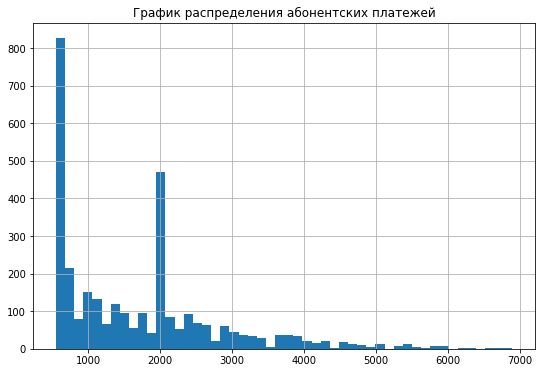

In [32]:
df_new['profit_per_sub'].hist(bins = 50, figsize = (9, 6));
plt.title('График распределения абонентских платежей');
df_new['profit_per_sub'].value_counts().head(5)

Как видим, наиболее часто встречающиеся платежи - это размеры абонентской платы по тарифам (1950 и 550 рублей).

## ОПИСАНИЕ ПОВЕДЕНИЯ КЛИЕНТОВ

### Анализ данных клиентов с тарифом Ultra

In [33]:
df_new_ultra = df_new[df_new['tariff'] == 'ultra']
df_new_ultra.nunique()

user_id           149
month              12
duration          641
calls_id          181
messages_id       177
mb_used           965
age                55
churn_date         14
city               57
first_name        117
last_name         141
reg_date          120
tariff              1
gb_used            48
profit_per_sub     32
dtype: int64

Тарифом ultra из нашей выборки пользуется 149 клиент или 29,8%.

#### Анализ необходимого количества минут для пользоваталей тарифа ultra

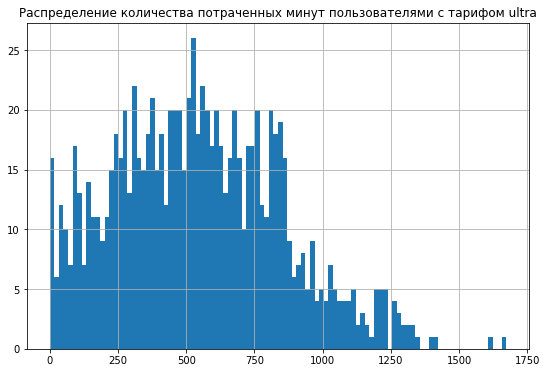

In [34]:
df_new_ultra['duration'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение количества потраченных минут пользователями с тарифом ultra');

count     938.000000
mean      539.443497
std       294.625927
min         1.000000
25%       310.250000
50%       525.000000
75%       752.000000
max      1297.000000
Name: duration, dtype: float64

Дисперсия количества потраченных минут пользователями с тарифом ultra после удаления выбросов: 86804


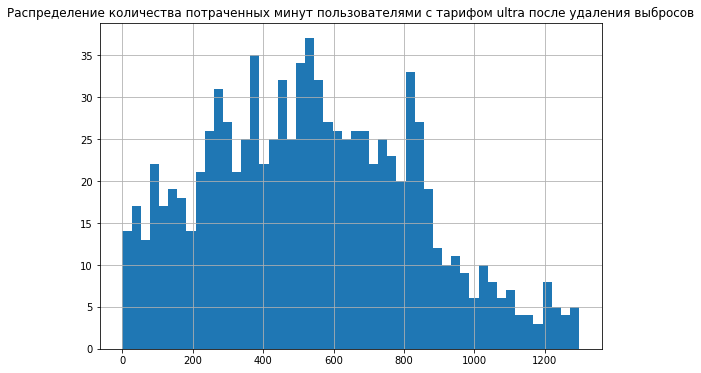

In [35]:
df_new_ultra_nonull_DURATION = df_new_ultra[(df_new_ultra['duration'] != 0)&(df_new_ultra['duration'] < 1300)] #больше 1300 всего 9 значений, данные
#значения существенно отличаются, поэтому можно считать их выбросами и исключить для дальнейшего анализа
df_new_ultra_nonull_DURATION['duration'].hist(bins = 50, figsize = (9, 6)); #присутствует скошенность вправо
plt.title('Распределение количества потраченных минут пользователями с тарифом ultra после удаления выбросов')
display(df_new_ultra_nonull_DURATION['duration'].describe())
print('Дисперсия количества потраченных минут пользователями с тарифом ultra после удаления выбросов:' , round(np.var(df_new_ultra_nonull_DURATION['duration'], ddof=1)))

Выделив данную группу можем получить ее описательные статистики:
- 540 минут в среднем ипроговаривают пользователи тарифа ultra
- 525 минут - медианное время разоговоров в месяц
- 295 - стандартное отклонение

Из всех пользователей нашей выборки никому не удалось потратить хотя бы половину доступного количества минут за месяц. Максимум, который наговорили некоторые пользователи составил 1297 минут, а половина пользователей вообще тратит не более 525 минут за месяц.

#### Анализ необходимого количества СМС для пользоваталей тарифа ultra

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_id, dtype: float64

Дисперсия количества потраченных смс пользователями с тарифом ultra после удаления выбросов: 1967


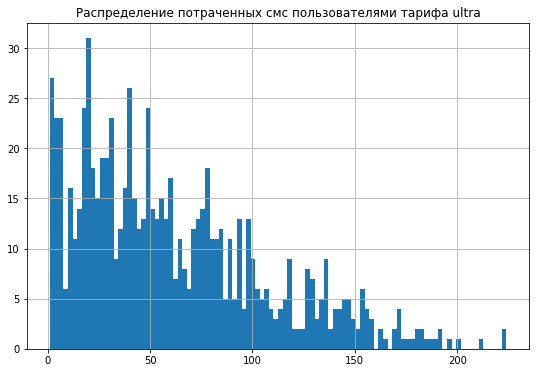

In [36]:
df_new_ultra['messages_id'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение потраченных смс пользователями тарифа ultra');
display(df_new_ultra['messages_id'].describe())
var_ultra_MESSAGES = np.var(df_new_ultra_nonull_DURATION['messages_id'], ddof=1)
print('Дисперсия количества потраченных смс пользователями с тарифом ultra после удаления выбросов:' , round(var_ultra_MESSAGES))

Для пользователей тарифа ultra доступно 1000 смс в месяц, но как можем увидеть из графика, такого количества смс не отправил ни один клиент ни в одном месяце. Максимальное количество смс, которое отправио клиент было 224 смс, а половина клиентов отправляет вообще не более 51 смс в месяц. Можем сделать вывод, что смс особым спросом не пользуются и у пользователей остается неиспользованной львиная доля того, за что они платят.

In [37]:
df_tariffs

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

#### Анализ необходимого количества мегабайт для пользоваталей тарифа ultra

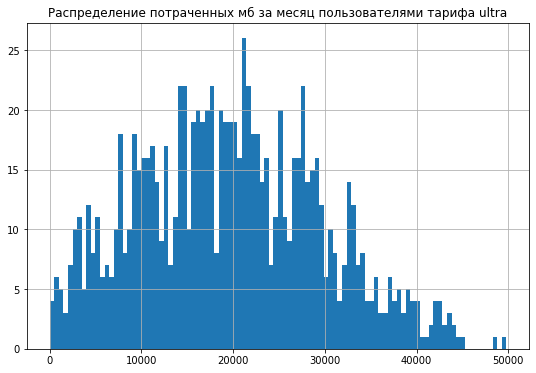

Количество значений больше 45000: 3


In [38]:
df_new_ultra['mb_used'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение потраченных мб за месяц пользователями тарифа ultra');
plt.show()
print('Количество значений больше 45000:', len(df_new_ultra['mb_used'][df_new_ultra['mb_used'] >= 45000]))

Дисперсия потраченных мб: 96591836


count      971.000000
mean     19620.177137
std       9828.114551
min        366.000000
25%      12020.500000
50%      19401.000000
75%      26867.000000
max      44341.000000
Name: mb_used, dtype: float64

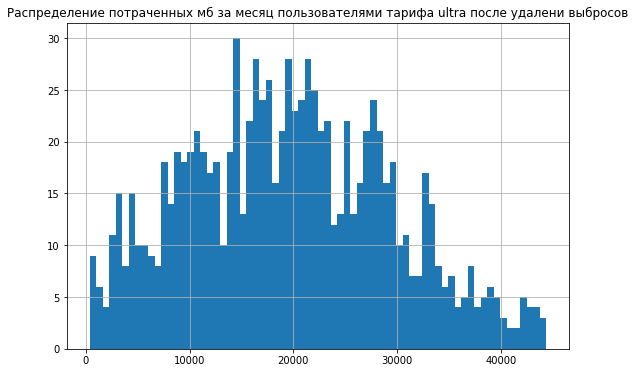

In [39]:
df_new_ultra_nonull_MB = df_new_ultra[(df_new_ultra['mb_used'] != 0)&(df_new_ultra['mb_used'] < 45000)]
var_ultra_MB = round(np.var(df_new_ultra_nonull_MB['mb_used'], ddof=1))
print('Дисперсия потраченных мб:', var_ultra_MB)

df_new_ultra_nonull_MB['mb_used'].hist(bins = 70, figsize = (9, 6));
plt.title('Распределение потраченных мб за месяц пользователями тарифа ultra после удалени выбросов');

display(df_new_ultra_nonull_MB['mb_used'].describe())

Посмотрим, сколько объектов, в которых потраченных мб в месяц больше, чем включено в тариф ultra (30720 мб).

In [40]:
display(df_new_ultra_nonull_MB[df_new_ultra_nonull_MB['mb_used'] > df_tariffs['mb_per_month_included'][1]].head())
print('Количество объектов, в которых превышен месячный лимит по интернету:', \
     (len(df_new_ultra_nonull_MB[df_new_ultra_nonull_MB['mb_used'] > df_tariffs['mb_per_month_included'][1]])))

user_id  month  duration  calls_id  messages_id  mb_used  age  \
159     1024   11.0    1146.0     157.0          NaN  43146.0   73   
160     1024   12.0     949.0     136.0          NaN  35985.0   73   
311     1050    7.0     209.0      35.0         52.0  35205.0   44   
383     1060   12.0    1233.0     184.0         52.0  43973.0   46   
783     1124   11.0    1127.0     160.0         95.0  36871.0   54   

     churn_date             city first_name  last_name    reg_date tariff  \
159         NaN  Санкт-Петербург     Иулиан    Антипов  2018-10-31  ultra   
160         NaN  Санкт-Петербург     Иулиан    Антипов  2018-10-31  ultra   
311  2018-10-03           Тюмень     Рузана   Аничкина  2018-06-16  ultra   
383         NaN           Калуга       Яков    Рудаков  2018-11-24  ultra   
783         NaN        Махачкала     Альбин  Андрианов  2018-09-24  ultra   

     gb_used  profit_per_sub  
159     43.0          6000.0  
160     36.0          4950.0  
311     35.0          4800.0  
383     43.0          6000.0  
783     37.0          5100.0

Количество объектов, в которых превышен месячный лимит по интернету: 131


### Вывод
Что мы можем сказать проанализировав поведение наших пользователей за выбранный период:
1. Пользователи тарифа ультра стабильно не используют даже половины доступных смс и минут за месяц.
2. Очень активно используется интернет. 

Поскольку для бизнеса важно предлагать продукт, который будет максимально соответствовать требованиям клиента, то может встать вопрос: сколько требуется звонков, сообщений, интернета для клиентов тарифа, чтобы его пользование было выгодным для них?

Я бы определил выгодность тарифа для клиента, как цена которую клиент уплачивает за услугу данной телеком компании. Если клиент с тарифом смарт платит за месяц больше, чем мог бы платить за тариф ультра, то стоит сменить тариф. Если же клиент, находясь на тарифе ультра, в среднем использует кол-во минут, мб или смс, которое соответствует или чуть больше того, что предоставляет тариф смарт, то выгоднее перейти на него. 

Создадим функцию, которая будет определять, выгоден ли тариф, который в данный момент использует клиент или же ему стоит задуматься о смене тарифа.

In [41]:
def benefit(row):
    if row['tariff'] == 'smart':
        if row['profit_per_sub'] < ULTRA_COST:
            return 'Тариф выгоден'
        else:
            return 'Лучше сменить на ultra'
    if row['tariff'] == 'ultra':
        if row['duration'] > SMART_MINUTES or row['messages_id'] > SMART_MESSAGES or row['mb_used'] > SMART_INTERNET_MB:
            return 'Стоит рассмотреть тариф ultra'
        else:
            'Тариф выгоден'

            
df_new['benefit'] = df_new.apply(benefit, axis = 1)
df_new.head()

user_id  month  duration  calls_id  messages_id  mb_used  age churn_date  \
0     1000    5.0     159.0      22.0         22.0   2256.0   52        NaN   
1     1000    6.0     172.0      43.0         60.0  23257.0   52        NaN   
2     1000    7.0     340.0      47.0         75.0  14016.0   52        NaN   
3     1000    8.0     408.0      52.0         81.0  14070.0   52        NaN   
4     1000    9.0     466.0      58.0         57.0  14581.0   52        NaN   

        city first_name  last_name    reg_date tariff  gb_used  \
0  Краснодар     Рафаил  Верещагин  2018-05-25  ultra      3.0   
1  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     23.0   
2  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     14.0   
3  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     14.0   
4  Краснодар     Рафаил  Верещагин  2018-05-25  ultra     15.0   

   profit_per_sub                        benefit  
0          1950.0                           None  
1          3000.0  Стоит рассмотреть тариф ultra  
2          1950.0  Стоит рассмотреть тариф ultra  
3          1950.0  Стоит рассмотреть тариф ultra  
4          1950.0  Стоит рассмотреть тариф ultra

Функция довольно простая по своей сути,  но тем не менее неплохо справляется с поставленной задачей: определить, выгоден ли тариф клиенту или нет. Также, функцию можно улучшить, поскольку делает вывод по основанию всего одного месяца. В идеале, такой совет должен даваться на основе дольшего периода (как минимум несколько месяцев) и большего количества информации.

### Анализ данных клиентов с тарифом Smart

In [42]:
df_new_SMART = df_new[df_new['tariff'] == 'smart']
df_new_SMART.nunique()

user_id            351
month               12
duration           732
calls_id           132
messages_id        123
mb_used           2104
age                 58
churn_date          20
city                72
first_name         212
last_name          313
reg_date           223
tariff               1
gb_used             39
profit_per_sub     709
benefit              2
dtype: int64

Тарифом smart из нашей выборки пользуется 351 клиент или 70,2%.

#### Анализ необходимого количества минут для пользоваталей тарифа smart

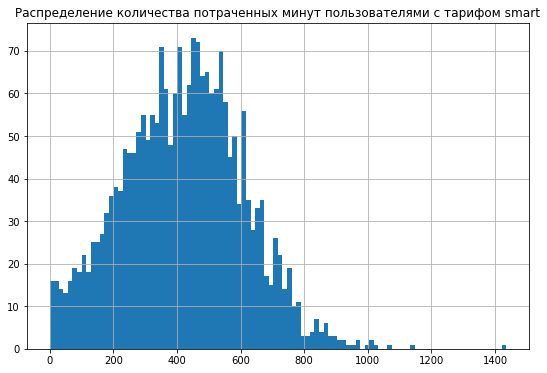

In [43]:
df_new_SMART['duration'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение количества потраченных минут пользователями с тарифом smart');

Основная масса звонков длится не более 1000 минут. Поэтому, все, что больше 1000 будем считать выбросами и не учитывать при анализе. Для начала посчтитаем, сколько у нас таких значений.

In [44]:
display(df_new_SMART[df_new_SMART['duration'] > 1000].head())
print('Количество значений больше 1000:', len(df_new_SMART[df_new_SMART['duration'] > 1000]))

user_id  month  duration  calls_id  messages_id  mb_used  age  \
1359     1216   12.0    1435.0     198.0         64.0  20095.0   74   
1452     1229   12.0    1022.0     128.0          6.0  25033.0   24   
1622     1261   12.0    1074.0     141.0         22.0  32697.0   46   
1998     1319   10.0    1005.0     127.0         48.0  18011.0   70   
2856     1451   12.0    1144.0     141.0         50.0  16971.0   58   

     churn_date              city first_name   last_name    reg_date tariff  \
1359        NaN         Волгоград     Рустам     Малинин  2018-11-23  smart   
1452        NaN            Москва      Нелли     Зубкова  2018-10-29  smart   
1622        NaN            Казань     Мадина  Пантелеева  2018-10-30  smart   
1998        NaN   Санкт-Петербург    Харитон    Парфенов  2018-08-24  smart   
2856        NaN  Набережные Челны   Виктория   Завьялова  2018-08-27  smart   

      gb_used  profit_per_sub                 benefit  
1359     20.0          4197.0  Лучше сменить на ultra  
1452     25.0          3916.0  Лучше сменить на ultra  
1622     32.0          5472.0  Лучше сменить на ultra  
1998     18.0          2465.0  Лучше сменить на ultra  
2856     17.0          2682.0  Лучше сменить на ultra

Количество значений больше 1000: 6


count    2215.000000
mean      417.557562
std       185.580479
min         2.000000
25%       285.000000
50%       422.000000
75%       544.500000
max      1000.000000
Name: duration, dtype: float64

Дисперсия количества потраченных минут пользователями с тарифом smart после удаления выбросов: 34440


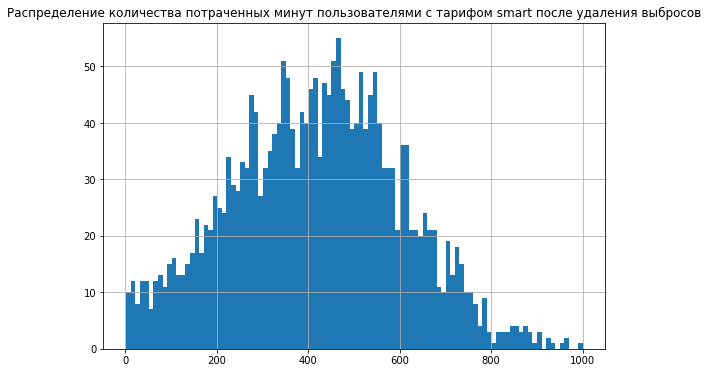

In [45]:
df_new_smart_nonull_DURATION = df_new_SMART[(df_new_SMART['duration'] != 0)&(df_new_SMART['duration'] <= 1000)]
df_new_smart_nonull_DURATION['duration'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение количества потраченных минут пользователями с тарифом smart после удаления выбросов');

display(df_new_smart_nonull_DURATION['duration'].describe())

print('Дисперсия количества потраченных минут пользователями с тарифом smart после удаления выбросов:' , round(np.var(df_new_smart_nonull_DURATION['duration'], ddof=1)))

На тарифе smart люди разговаривают в среднем 417 минут, медианное время 422 минуты.

#### Анализ необходимого количества СМС для пользоваталей тарифа smart

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_id, dtype: float64

Дисперсия количества потраченных смс пользователями с тарифом ultra после удаления выбросов: 720


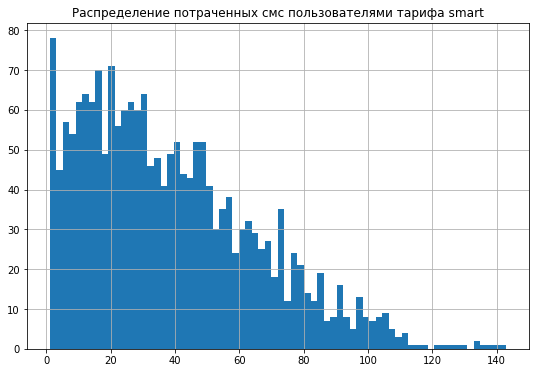

In [46]:
df_new_SMART['messages_id'].hist(bins = 70, figsize = (9, 6));
plt.title('Распределение потраченных смс пользователями тарифа smart');
display(df_new_SMART['messages_id'].describe())

var_smart_MESSAGES = np.var(df_new_smart_nonull_DURATION['messages_id'], ddof=1)

print('Дисперсия количества потраченных смс пользователями с тарифом ultra после удаления выбросов:' , round(var_smart_MESSAGES))

#### Анализ необходимого количества мегабайт для пользоваталей тарифа smart

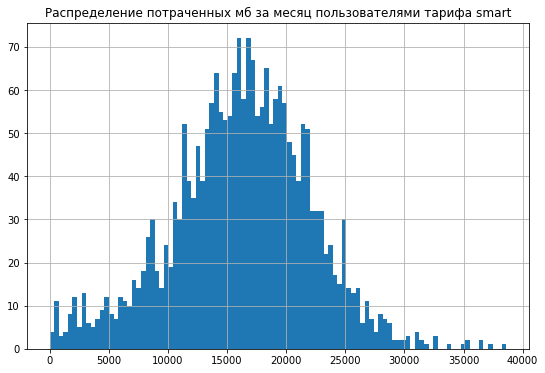

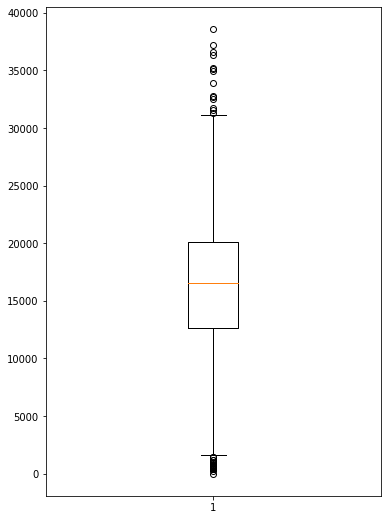

In [47]:
df_new_SMART['mb_used'].hist(bins = 100, figsize = (9, 6));
plt.title('Распределение потраченных мб за месяц пользователями тарифа smart');
plt.show()

no_na = df_new_SMART['mb_used'].dropna()
plt.figure(figsize = (6, 9))
box = plt.boxplot(x = no_na);

На глаз определить выбросы сложно, поэтому воспользуемся диаграммой размаха и посмотри на границы усов.

In [48]:
upper_whisker = [el.get_ydata()[1] for el in box['whiskers']][1]
upper_whisker

31115.0

Получили такую верхнюю границу. Отныне будем считать, что все, что лежит за пределами данной границы будет считаться выбросом.

In [49]:
df_new_SMART_no_fliers = df_new_SMART[df_new_SMART['mb_used'] >= 31115]
len(df_new_SMART[df_new_SMART['mb_used'] >= 31115])

15

Всего получилось 15 выбросов. Немного.

In [50]:
df_new_SMART_no_fliers = df_new_SMART[df_new_SMART['mb_used'] < 31115]

In [51]:
df_new_SMART_no_fliers['mb_used'].describe()

count     2213.000000
mean     16115.305016
std       5697.305673
min          0.000000
25%      12633.000000
50%      16484.000000
75%      20000.000000
max      31054.000000
Name: mb_used, dtype: float64

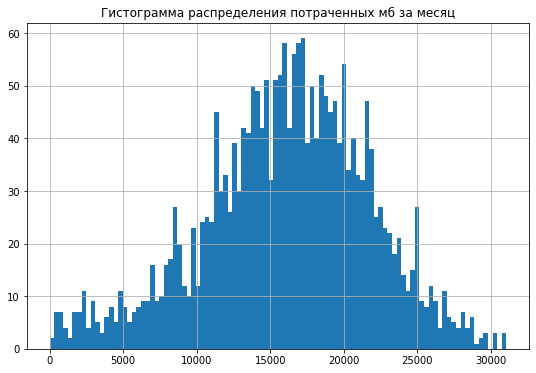

In [52]:
df_new_SMART_no_fliers['mb_used'].hist(bins = 100, figsize = (9, 6));
plt.title('Гистограмма распределения потраченных мб за месяц');

### Вывод
Исходя из проведенного анализа можно сделать следующие выводы:

1.Клиенты с тарифом ультра в среднем используют больше минут, 540 против 419 у smart

2.Клиенты с тарифом ультра в среднем используют больше смс, 62 против 39 у smart

3.Клиенты с тарифом ультра в среднем используют больше мб интернета, 19707 против 16244 у smart

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [53]:
df_new_ultra_PROFIT_mean = df_new_ultra['profit_per_sub'].mean()
print('Средний размер ежемесячного платежа у клиента с тарифом ultra составил:', round(df_new_ultra_PROFIT_mean), 'руб.')

df_new_smart_PROFIT_mean = df_new_SMART['profit_per_sub'].mean()
print('Средний размер ежемесячного платежа у клиента с тарифом ultra составил:', round(df_new_smart_PROFIT_mean), 'руб.')
print()

alpha = .05

results = st.ttest_ind(df_new_ultra['profit_per_sub'], df_new_SMART['profit_per_sub'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний размер ежемесячного платежа у клиента с тарифом ultra составил: 2845 руб.
Средний размер ежемесячного платежа у клиента с тарифом ultra составил: 1177 руб.

p-значение: 0.0
Отвергаем нулевую гипотезу


#### Вывод
Был проведен тест на проверку гипотезы о равенстве средних двух генеральных совокупностей, то есть равенство средней доходности между пользователями тарифа ultra и smart. P-критерий практически равен 0, что означает, что нулевая гипотеза (о равенстве средних двух генеральных совокупностей) отклоняется и средние не равны.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [54]:
moscow_data = df_new[df_new['city'] == 'Москва']['profit_per_sub']
moscow_data_mean = df_new[df_new['city'] == 'Москва']['profit_per_sub'].mean() #1593
not_moscow_data = df_new[df_new['city'] != 'Москва']['profit_per_sub']
not_moscow_data_mean = df_new[df_new['city'] != 'Москва']['profit_per_sub'].mean() #1573

alpha = .05

results = st.ttest_ind(moscow_data, not_moscow_data)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
moscow_data_mean, not_moscow_data_mean

p-значение: 0.0005700353414778723
Отвергаем нулевую гипотезу


(1833.620294599018, 1654.3604606525912)

#### Вывод
Был проведен тест на проверку гипотезы о равенстве средней выручки между пользователями из Москвы и из других регионов(гипотеза о равенстве средних двух генеральных совокупностей). P-значение равно 0.59, что о говорит о том, что с вероятностью почти 60% можно получить данное или большее различие в средних случайно. Поэтому говорить о том, что данная разница значима не можем.

## Вывод


In [55]:
total_income_ultra = df_new_ultra['profit_per_sub'].sum()
print('Совокупный доход с клиентов с тарифом ultra составил:', total_income_ultra, 'руб.')

total_income_smart = df_new_SMART['profit_per_sub'].sum()
print('Совокупный доход с клиентов с тарифом smart составил:', total_income_smart, 'руб.')
print('')

df_new_ultra_clients = len(df_new_ultra['user_id'].unique()) #149 уникальных пользователей с тарифом ultra
print('Уникальных пользователей с тарифом ultra:', df_new_ultra_clients)

df_new_smart_clients = len(df_new_SMART['user_id'].unique()) #351 уникальный пользователь с тарифом smart
print('Уникальных пользователей с тарифом smart:', df_new_smart_clients)

Совокупный доход с клиентов с тарифом ultra составил: 2805450.0 руб.
Совокупный доход с клиентов с тарифом smart составил: 2624501.0 руб.

Уникальных пользователей с тарифом ultra: 149
Уникальных пользователей с тарифом smart: 351


- Клиенты с тарифом ультра в среднем используют больше минут, 539 против 417 у smart
- Клиенты с тарифом ультра в среднем используют больше смс, 61 против 39 у smart
- Клиенты с тарифом ультра в среднем используют больше мб интернета, 19620 против 16115 у smart
- Средняя выручка с клиентов с тарифом ultra 2845 рублей в меясяц
- Средняя выручка с клиентов с тарифом smart 1177 рублей в меясяц

Главной задачей ставилось проведение анализа поведения клиентов с различными тарифами с дальнейшим определением того, какой тариф лучше. Из проведенного анализа можно сделать следующие выводы:
1. Клиенты с тарифом ultra потребляют больше интернета, отправляют больше смс и дольше разговаривают по телефону, но при этом и средняя плата с таких клиентов выше. Клиентов с тарифом ultra меньше, чем клиентов с тарифом smart более, чем в 2 раза.
2. На основе проведенного тестировния гипотез можно утверждать, что:
    А) Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
    Б) Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
3. Сложно выделить какой - либо тариф, который был бы намного выгоднее другого. Предполагаю, что оба тарифа являются незаменимыми, поскольку рассчитаны на разные потребности людей. Те, кто активнее пользуются телефоном предпочитают платить больше и выбирают тариф ultra, те, кто телефоном пользуются меньше, выбирают smart, чтобы не переплачивать.